In [1]:
import pandas as pd
import math
import numpy as np
import time

import seaborn as sns

In [2]:
name = 'NBA'
output_folder  = '{}/{}'.format('data', name)
simFile = '{}/similarity'.format(output_folder)

In [3]:
insight_df = pd.read_csv('./rawData/{}/insight.csv'.format(name))
subspace_df = pd.read_csv('./rawData/{}/subspace.csv'.format(name))

# insight_columns: insights columns
# subspace_columns: subspaces

insight_columns = insight_df.columns[:10]
subspace_columns = subspace_df.columns

result_df = insight_df[insight_columns].merge(subspace_df, left_on='sid', right_on='sid')
result_df['index'] = result_df.index

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
result_df.groupby(['team_name']).count()

,breakdown,breakdown_value,measure,sig,impact,insight,insight_type,score,iid,sid,name,year,age,lg_name,pos_name,index
team_name,,,,,,,,,,,,,,,,
*,501,501,501,501,501,501,501,501,501,501,501,501,501,501,501,501
Atlanta Hawks,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Boston Celtics,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
Brooklyn Nets,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Chicago Bulls,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Cleveland Cavaliers,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Detroit Pistons,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
Golden State Warriors,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
Houston Rockets,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6


In [6]:
# A: features used  to calculate similarity
# M: the size of data

A = ['breakdown', 'measure'] + list(subspace_columns)[:-1]
N = result_df.shape[0]

In [7]:
# function f(k, x); funciton p(k, x) p2(k, x)

kx_map = {}
for (k, a) in enumerate(A):
    if k not in kx_map:
        kx_map[k] = {}
    x_count = result_df[[a, 'index']].groupby(a).count().reset_index()
    for obj in x_count.to_dict('records'):
        kx_map[k][obj[a]] = obj['index']
        
        
def f(k, x):
    if k not in kx_map:
        return False
    if x not in kx_map[k]:
        return 0
    return kx_map[k][x]

insight_records= result_df.to_dict('records')

def p(k, x):
    fkx = f(k, x)
    if fkx == False:
        return False
    return fkx / N

def p2(k, x):
    fkx = f(k,x)
    if fkx == False:
        return False
    return fkx * (fkx-1) / (N * (N-1)) 

def linw(src, dst):
    s = 0
    for (k, a) in enumerate(A):
        Xk, Yk =  src[a], dst[a]
        s += (np.log(p(k, Xk)) + np.log(p(k, Yk))) 
    return 1/s 

def linS(k, src, dst):
    key = A[k]
    Xk, Yk = src[key], dst[key]
    if Xk == Yk:
        return 2 * np.log(p(k, Xk))
    return 2*np.log2(p(k, Xk) + p(k, Yk))

def lin(src, dst):
    w = linw(src, dst)
    sim = 0
    for (k, a) in enumerate(A):
        sim += w*(linS(k, src, dst))
    return sim


In [8]:
simMatrix = np.zeros((N, N))
start_time = time.time()

for i in range(0, len(insight_records)):
    src = insight_records[i]
    for j in range(i+1, len(insight_records)):
        dst = insight_records[j]
        simMatrix[i][j] = float(lin(src, dst))
        simMatrix[j][i] = simMatrix[i][j]

end_time = time.time()
print('use time ', end_time - start_time)

use time  6.646453380584717


In [9]:
np.savez(simFile, sim = simMatrix)

In [10]:
simFile

'data/NBA/similarity'

In [11]:
up = np.load("{}.npz".format(simFile))

## Calculate projection

In [66]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import spectral_embedding
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

In [69]:
def generate_projection(sim_matrix, perplexity = 12):
    
    st = time.time()
    X_embedded = TSNE(n_components=2, 
                   init='random', perplexity=perplexity).fit_transform(sim_matrix)

#     X_embedded = MDS(n_components=2).fit_transform(sim_matrix)
    
#     X_embedded = spectral_embedding(sim_matrix, n_components=2)
    print(time.time() - st)
    return X_embedded

def visualize_matrix(projection, cluster_labels):
    df = pd.DataFrame(columns=['x', 'y'], data=projection)
    df['cluster'] = cluster_labels
    sns.scatterplot(data=df, x="x", y="y",  hue='cluster', palette="deep")

    def best_clustering(X_embedded, min_cluster=2, max_cluster = 50):
    max_score = -1
    max_labels = None
    for i in range(min_cluster, max_cluster):
        clustering = AgglomerativeClustering(n_clusters = i).fit(X_embedded)
        score = silhouette_score(
            X_embedded,
            clustering.labels_,
            metric="euclidean",
        )
            
        if max_score < score:
            max_score = score
            max_labels = clustering.labels_
    return score, i, max_labels

def best_clustering(X_embedded, min_cluster=2, max_cluster = 50):
    max_score = -1
    max_labels = None
    for i in range(min_cluster, max_cluster):
        clustering = AgglomerativeClustering(n_clusters = i).fit(X_embedded)
        score = silhouette_score(
            X_embedded,
            clustering.labels_,
            metric="euclidean",
        )

        if max_score < score:
            max_score = score
            max_labels = clustering.labels_
    return score, i, max_labels

    
    
def calc_projection(sim, index_list, perplexity = 50, n_clusters = 15):
    matrix = sim if type(sim) != str else np.load(simFile.format(output_folder, 'npz'))
    sub_matrix = matrix[index_list][:, index_list]
    X_embedded = generate_projection(sub_matrix, perplexity)
    start_time = time.time()
#     clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(X_embedded)
#     clustering = AffinityPropagation(preference=-50, random_state=0).fit(X_embedded)
#     clustering = DBSCAN(eps=0.01, min_samples=50).fit(X_embedded)
    
#     score = silhouette_score(
#             X_embedded,
#             clustering.labels_,
#             metric="euclidean",
#         )
    score, n, labels = best_clustering(X_embedded)
    print('score', score, score, n)
    print('Use time', time.time() - start_time)
    return X_embedded, labels



In [91]:
best_clustering(X_embedded = projection)

(0.6687047,
 49,
 array([19, 13, 15,  0,  4, 13, 15, 11, 12, 33, 12, 33, 12, 12, 26, 25, 25,
         1,  1,  1,  2, 24,  2,  2,  1,  1,  1,  2, 24,  2,  2,  1,  2, 19,
        18, 19, 18,  0, 27,  4,  0,  0,  0, 27,  4,  6,  4,  4,  6,  6, 29,
         1,  1,  1,  2, 24,  2,  2,  0, 27,  0,  0, 27,  4,  6,  4,  4,  6,
         6,  4, 29, 29, 29,  0, 27,  0,  0, 27,  4,  6,  6,  4,  4,  6,  6,
        29,  0, 27,  0,  0, 27,  4,  6,  6,  4,  4,  6, 19, 22, 19, 19, 18,
        22, 22, 18, 18, 22, 22, 19, 18, 13, 30, 13, 13, 30, 11, 10, 10, 11,
        11, 10, 10, 10, 13, 15, 11, 13, 15, 11, 10,  1,  1,  2,  0,  0, 27,
         4,  6,  1,  1,  1,  2, 24,  2,  2,  0,  0,  0, 27,  4,  6,  4,  4,
         6,  6, 29, 29, 29, 12, 33, 33, 12, 12, 33, 25, 26, 26, 25, 25, 26,
        28,  3,  3,  3, 28,  3,  3,  1,  1,  1,  2, 24,  2,  2, 24, 24, 12,
        33, 12, 12, 33, 25, 26, 25, 25, 26,  3,  3, 28,  3, 28,  3,  3, 21,
        32, 21, 21, 23, 31, 31, 23, 23, 20,  7,  7, 20,  7,  7,  7,  1,

1.152496576309204
score 0.74909186
Use time 0.017964839935302734


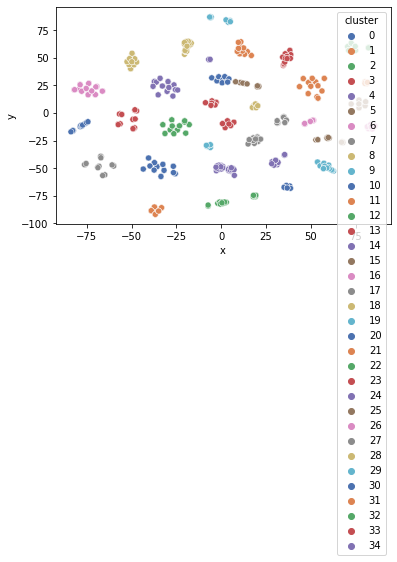

In [82]:
projection, cluster_labels = calc_projection(simMatrix, [i for i in range(0, 650)], perplexity=5, n_clusters=35)
visualize_matrix(projection, cluster_labels)


In [80]:
for i in range(2, 100):
    clustering = AgglomerativeClustering(n_clusters = i).fit(projection)
    score = silhouette_score(
            projection,
            clustering.labels_,
            metric="euclidean",
        )
    print(i, score)

2 0.335047
3 0.34843543
4 0.32067773
5 0.30916193
6 0.3432839
7 0.36026883
8 0.3894017
9 0.40492
10 0.4209225
11 0.44186044
12 0.45847243
13 0.4776895
14 0.4964586
15 0.5111403
16 0.52219135
17 0.5351648
18 0.5519566
19 0.5650296
20 0.580535
21 0.59526396
22 0.61579686
23 0.6216313
24 0.6358254
25 0.65107816
26 0.6631305
27 0.6738092
28 0.68581414
29 0.69931495
30 0.712332
31 0.72369236
32 0.73142385
33 0.7314494
34 0.73945785
35 0.7443891
36 0.7317309
37 0.71874285
38 0.7073461
39 0.6967237
40 0.68182796
41 0.6686674
42 0.6723006
43 0.66371506
44 0.66932887
45 0.6748631
46 0.6700989
47 0.6699026
48 0.6705286
49 0.6724535
50 0.6756974
51 0.6704802
52 0.6626
53 0.6613364
54 0.6530482
55 0.65234035
56 0.6512561
57 0.6447098
58 0.6424707
59 0.64272034
60 0.64898825
61 0.6554341
62 0.65440536
63 0.6584242
64 0.6619799
65 0.6635751
66 0.6647549
67 0.67139083
68 0.6623111
69 0.668663
70 0.6716164
71 0.67452776
72 0.6757157
73 0.67670614
74 0.67899364
75 0.67881066
76 0.6819819
77 0.67305446


In [81]:
cluster_labels

array([ 5,  8, 11,  1,  4,  8, 11,  1, 14,  2, 14,  2, 14, 14,  7,  8,  8,
        7,  7,  7,  0,  8,  0,  0,  7,  7,  7,  0,  8,  0,  0,  7,  0,  5,
        0,  5,  0,  1,  6,  4,  1,  1,  1,  6,  4, 10,  4,  4, 10, 10,  4,
        7,  7,  7,  0,  8,  0,  0,  1,  6,  1,  1,  6,  4, 10,  4,  4, 10,
       10,  4,  4,  4,  4,  1,  6,  1,  1,  6,  4, 10, 10,  4,  4, 10, 10,
        4,  1,  6,  1,  1,  6,  4, 10, 10,  4,  4, 10,  5,  3,  5,  5,  0,
        3,  3,  0,  0,  3,  3,  5,  0,  8, 11,  8,  8, 11,  1,  6,  6,  1,
        1,  6,  6,  6,  8, 11,  1,  8, 11,  1,  6,  7,  7,  0,  1,  1,  6,
        4, 10,  7,  7,  7,  0,  8,  0,  0,  1,  1,  1,  6,  4, 10,  4,  4,
       10, 10,  4,  4,  4, 14,  2,  2, 14, 14,  2,  8,  7,  7,  8,  8,  7,
        0,  5,  5,  5,  0,  5,  5,  7,  7,  7,  0,  8,  0,  0,  8,  8, 14,
        2, 14, 14,  2,  8,  7,  8,  8,  7,  5,  5,  0,  5,  0,  5,  5, 12,
        6, 12, 12,  6,  0,  0,  6,  6,  3, 13, 13,  3, 13, 13, 13,  7,  7,
        7,  0,  8,  0,  0

In [92]:
x = np.array([1,2,3,4,5,6])

In [95]:
x.reshape(x.shape[0], 1)

SyntaxError: invalid syntax (Temp/ipykernel_5260/3152294150.py, line 1)

In [32]:
cluster.labels_

array([0, 0, 0, 4, 4, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 3,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 0, 0, 0, 4, 3, 4, 4, 4, 4, 3,
       4, 3, 4, 4, 3, 3, 3, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 3, 4, 3, 4,
       4, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 4, 3, 3, 3, 4, 3,
       4, 4, 3, 4, 3, 3, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4,
       4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3,
       3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 4, 4, 3, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       4, 4, 4, 3, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 4, 3, 4, 4, 3, 4, 3, 4, 4,

In [ ]:
np.savez("{}/{}.npz".format(output_folder, 'projection'), projection = projection)

In [ ]:
type('123') == str

In [ ]:
emb = calc_projection(simMatrix, [i for i in range(0, 649)], perplexity=12)
visualize_matrix(emb)

In [ ]:
test_index = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
test_index = [i for i in range(0, 374)]
sub_similarity = simMatrix[test_index][:, test_index]

In [ ]:
sub_similarity

In [ ]:
X_embedded = generate_projection(sub_similarity, 99)
visualize_matrix(X_embedded)

In [ ]:
simMatrix[[1,2,3]][:, [1,2,3]].shape

In [ ]:
simMatrix[[1,5,7]][:, [1,5,7]]

In [ ]:
simMatrix[[1]]

## Save similarity matrix

In [ ]:

start_time = time.time()
X_embedded = TSNE(n_components=2, 
                   init='random', perplexity=12).fit_transform(simMatrix)
print("Use time: ", time.time() - start_time)

projection = pd.DataFrame(columns=['x', 'y'], data = X_embedded)
sns.scatterplot(data=projection, x="x", y="y")

In [ ]:
result_df[['x', 'y']] = projection.values
result_df.to_csv('projection.csv', index = False)

In [ ]:
def generate_projection():
    pass

## process subspace

In [ ]:
sub_df = result_df[result_df['team_name'] == 'Los Angeles Lakers']

sub_N = sub_df.shape[0]
sub_simMatrix = np.zeros((sub_N, sub_N))
start_time = time.time()
sub_insight_records = sub_df.to_dict('records')
for i in range(0, len(sub_insight_records)):
    src = sub_insight_records[i]
    for j in range(i+1, len(sub_insight_records)):
        dst = sub_insight_records[j]
        sub_simMatrix[i][j] = float(lin(src, dst))
        sub_simMatrix[j][i] = sub_simMatrix[i][j]

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
sub_embedded = TSNE(n_components=2, 
                   init='random', perplexity=5).fit_transform(sub_simMatrix)
print("Use time: ", time.time() - start_time)

sub_projection = pd.DataFrame(columns=['x', 'y'], data = sub_embedded)
sns.scatterplot(data=sub_projection, x="x", y="y")

In [ ]:
sub_df[['x', 'y']] = sub_projection.values
sub_df.to_csv('subspace.csv', index = False)

## breakdown subspace

In [ ]:
result_df['breakdown'].unique()

In [ ]:
result_df[['breakdown','age']].groupby('breakdown').count()

In [ ]:
result_df[['lg_name','age']].groupby('lg_name').count()

In [ ]:
breakdown_df = result_df[result_df['breakdown'] == 'lg_name']

breakdown_N = breakdown_df.shape[0]
breakdown_simMatrix = np.zeros((breakdown_N, breakdown_N))
start_time = time.time()
breakdown_insight_records = breakdown_df.to_dict('records')
for i in range(0, len(breakdown_insight_records)):
    src = breakdown_insight_records[i]
    for j in range(i+1, len(breakdown_insight_records)):
        dst = breakdown_insight_records[j]
        breakdown_simMatrix[i][j] = float(lin(src, dst))
        breakdown_simMatrix[j][i] = breakdown_simMatrix[i][j]
        

end_time = time.time()
print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
breakdown_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(breakdown_simMatrix)
print("Use time: ", time.time() - start_time)

breakdown_projection = pd.DataFrame(columns=['x', 'y'], data = breakdown_embedded)
sns.scatterplot(data=breakdown_projection, x="x", y="y")

In [ ]:
breakdown_df[['x', 'y']] = breakdown_projection.values
breakdown_df.to_csv('breakdown.csv', index = False)

## breakdown  and  subspace

In [ ]:
bs_df = result_df[(result_df['breakdown'] == 'lg_name')&(result_df['team_name'] == 'Los Angeles Lakers')]

bs_N = bs_df.shape[0]
bs_simMatrix = np.zeros((bs_N, bs_N))
start_time = time.time()
bs_insight_records = bs_df.to_dict('records')
for i in range(0, len(bs_insight_records)):
    src = bs_insight_records[i]
    for j in range(i+1, len(bs_insight_records)):
        dst = bs_insight_records[j]
        bs_simMatrix[i][j] = float(lin(src, dst))
        bs_simMatrix[j][i] = bs_simMatrix[i][j]
        

# end_time = time.time()
# print('use time ', end_time - start_time)

In [ ]:
tart_time = time.time()
bs_embedded = TSNE(n_components=2, 
                   init='random', perplexity=50).fit_transform(bs_simMatrix)
print("Use time: ", time.time() - start_time)

bs_projection = pd.DataFrame(columns=['x', 'y'], data = bs_embedded)
sns.scatterplot(data=bs_projection, x="x", y="y")

In [ ]:
bs_df[['x', 'y']] = bs_projection.values
bs_df.to_csv('bs.csv', index = False)

In [ ]:
result_df['year'].shape